<a href="https://colab.research.google.com/github/kaisei3506/close_price_prediction/blob/main/past60days_future1month_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [79]:
!pip install japanize_matplotlib
import japanize_matplotlib

In [80]:
# 再現性確保

import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [81]:
df = pd.read_csv('/content/drive/MyDrive/assignment-main(new)/Trainee/time-series-prediction/my_cleaned_stock_price.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df

,close,open,high,low,volume,return
date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,0.1625
1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-0.0543
1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,0.0174
1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,0.0393
1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,0.0482
...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,1.550800e+08,-0.0013
2024-07-29,159.7,158.7,160.2,158.4,1.262800e+08,0.0114
2024-07-30,158.7,158.8,159.2,158.0,1.381400e+08,-0.0063


In [82]:
import holidays

def compute_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def engineer(df_old):

  df_new = df_old.copy()

  df_new['sin_dayofyear'] = np.sin(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['cos_dayofyear'] = np.cos(2 * np.pi * df_new.index.dayofyear / 365)
  df_new['sin_dayofmonth'] = np.sin(2 * np.pi * df_new.index.day / 30)
  df_new['cos_dayofmonth'] = np.cos(2 * np.pi * df_new.index.day / 30)
  df_new['sin_dayofweek'] = np.sin(2 * np.pi * df_new.index.dayofweek / 7)
  df_new['cos_dayofweek'] = np.sin(2 * np.pi * df_new.index.dayofweek / 7)

  # 日本の休日
  jp_holidays = holidays.Japan()
  df_new['holiday'] = df_new.index.map(lambda x: 1 if x in jp_holidays else 0)

  # 移動平均、相対力指数
  sma_list = [5, 10, 20, 60]
  for i in sma_list:
    df_new[f'sma_{i}'] = df_new['close'].rolling(window=i).mean()
    df_new[f'ema_{i}'] = df_new['close'].ewm(span=i, adjust=False).mean()
    df_new[f'rsi_{i}'] = compute_rsi(df_new, window=i)
  '''
  # 標準偏差
  for i in sma_list:
    df_new[f'std_{i}'] = df_new['close'].rolling(window=i).std()

  # 急激な上昇をとらえる
  for i in range(len(sma_list)):
    for j in range(i+1, len(sma_list)):
      df_new[f'sma_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'sma_{sma_list[i]}'] / df_new[f'sma_{sma_list[j]}']
      # ゴールデンクロス
      df_new[f'gc_{sma_list[i]}vs{sma_list[j]}'] = (df_new[f'sma_{sma_list[i]}'].shift(1) < df_new[f'sma_{sma_list[j]}'].shift(1)) & (df_new[f'sma_{sma_list[i]}'] >= df_new[f'sma_{sma_list[j]}'])
      # デッドクロス
      df_new[f'dc_{sma_list[i]}vs{sma_list[j]}'] = (df_new[f'sma_{sma_list[i]}'].shift(1) > df_new[f'sma_{sma_list[j]}'].shift(1)) & (df_new[f'sma_{sma_list[i]}'] <= df_new[f'sma_{sma_list[j]}'])
      # MACD
      df_new[f'macd_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'ema_{sma_list[i]}'] - df_new[f'ema_{sma_list[j]}']
      df_new[f'macd_signal_{sma_list[i]}vs{sma_list[j]}'] = df_new[f'macd_{sma_list[i]}vs{sma_list[j]}'].ewm(span=9, adjust=False).mean()

  # ADX
  epsilon = 1e-6
  df_new['+DM'] = df_new['high'] - df_new['high'].shift(1)
  df_new['-DM'] = df_new['low'].shift(1) - df_new['low']
  df_new['TR'] = np.maximum.reduce([
    df_new['high'] - df_new['low'],
    abs(df_new['high'] - df_new['close'].shift(1)),
    abs(df_new['low'] - df_new['close'].shift(1))
    ])
  df_new['+DI'] = df_new['+DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['-DI'] = df_new['-DM'].rolling(window=14).sum() / (df_new['TR'].rolling(window=14).sum() + epsilon) * 100
  df_new['DX'] = abs((df_new['+DI'] - df_new['-DI']) / (df_new['+DI'] + df_new['-DI'] + epsilon)) * 100
  df_new['ADX'] = df_new['DX'].rolling(window=14).mean()

  # ストキャスティクス
  df_new['%K'] = (df_new['close'] - df_new['low'].rolling(window=14).min()) / (df_new['high'].rolling(window=14).max() - df_new['low'].rolling(window=14).min()) * 100
  df_new['%D'] = df_new['%K'].rolling(window=3).mean()
  '''


  #df_new = df_new.drop(['open', 'high', 'low'], axis=1)


  return df_new

engineered_df = engineer(df)
engineered_df

,close,open,high,low,volume,return,sin_dayofyear,cos_dayofyear,sin_dayofmonth,cos_dayofmonth,...,rsi_5,sma_10,ema_10,rsi_10,sma_20,ema_20,rsi_20,sma_60,ema_60,rsi_60
date,,,,,,,,,,,,,,,,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.280000e+09,0.1625,0.674444,0.738326,5.877853e-01,-0.809017,...,NaN,NaN,182.400000,NaN,NaN,182.400000,NaN,NaN,182.400000,NaN
1987-02-13,172.5,176.5,176.5,172.5,4.223800e+08,-0.0543,0.687053,0.726608,4.067366e-01,-0.913545,...,NaN,NaN,180.600000,NaN,NaN,181.457143,NaN,NaN,182.075410,NaN
1987-02-16,175.5,166.7,175.5,165.7,3.605100e+08,0.0174,0.723644,0.690173,-2.079117e-01,-0.978148,...,NaN,NaN,179.672727,NaN,NaN,180.889796,NaN,NaN,181.859823,NaN
1987-02-17,182.4,176.5,184.3,175.5,8.815100e+08,0.0393,0.735417,0.677615,-4.067366e-01,-0.913545,...,NaN,NaN,180.168595,NaN,NaN,181.033625,NaN,NaN,181.877533,NaN
1987-02-18,191.2,186.3,191.2,186.3,7.950900e+08,0.0482,0.746972,0.664855,-5.877853e-01,-0.809017,...,65.384615,NaN,182.174305,NaN,NaN,182.001851,NaN,NaN,182.183188,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,1.550800e+08,-0.0013,-0.425000,-0.905193,-7.431448e-01,0.669131,...,37.777778,159.05,158.512757,43.442623,157.765,157.313736,61.458333,155.301667,158.314262,42.066421
2024-07-29,159.7,158.7,160.2,158.4,1.262800e+08,0.0114,-0.471160,-0.882048,-2.079117e-01,0.978148,...,48.148148,159.15,158.728619,53.787879,158.160,157.541000,63.122924,155.121667,158.359696,43.478261
2024-07-30,158.7,158.8,159.2,158.0,1.381400e+08,-0.0063,-0.486273,-0.873807,-1.133108e-15,1.000000,...,32.142857,159.30,158.723416,55.905512,158.285,157.651381,54.681648,154.926667,158.370854,43.010753


In [83]:
train_valid = engineered_df['2020-01-01':'2023-12-31']

train = train_valid[:'2022-12-31']
enbargo_train_valid = train_valid['2023-01-01':'2023-03-31']
valid = train_valid['2023-01-01':'2023-12-31']
enbargo_valid_test = engineered_df['2023-09-01':'2024-06-30']
test = engineered_df['2024-07-01':'2024-07-31']

In [84]:
sequence_length = 60
predict_length = len(test)

def create_dataset(data, sequence_length, predict_length):
  X, y = [], []
  for i in range(len(data) - sequence_length - predict_length + 1):
    X.append(data[i:i+sequence_length, :])
    y.append(data[i+sequence_length:i+sequence_length+predict_length, 0])
  return np.array(X), np.array(y)

X_train, y_train = create_dataset(train.values, sequence_length, predict_length)
X_valid, y_valid = create_dataset(valid.values, sequence_length, predict_length)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(650, 60, 25)
(650, 22, 1)
(165, 60, 25)
(165, 22, 1)


In [85]:
from sklearn.preprocessing import StandardScaler

# 特徴量（X）のスケーリング
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_valid_scaled = scaler_X.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)

# 目的変数（y）のスケーリング
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, y_valid.shape[-1])).reshape(y_valid.shape)

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers as optim
from tensorflow.keras import regularizers

Epoch 1/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 1.8160 - val_loss: 2.9352
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 677ms/step - loss: 1.2248 - val_loss: 2.0191
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - loss: 1.0622 - val_loss: 1.5014
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 615ms/step - loss: 0.8763 - val_loss: 1.2033
Epoch 5/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 603ms/step - loss: 0.8075 - val_loss: 1.1010
Epoch 6/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 469ms/step - loss: 0.6933 - val_loss: 1.0355
Epoch 7/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - loss: 0.6518 - val_loss: 1.0591
Epoch 8/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 553ms/step - loss: 0.5802 - val_loss: 1.0156
Epoch 9/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 674ms/step - loss: 0.5315 - val_loss: 0.8547
Epoch 10/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 491ms/step - loss: 0.5014 - val_loss: 1.0940
Epoch 11/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 721ms/step - loss: 0.4772 - val_loss: 0.8786
Epoch 12/1000
11/11 ━━━━━━━

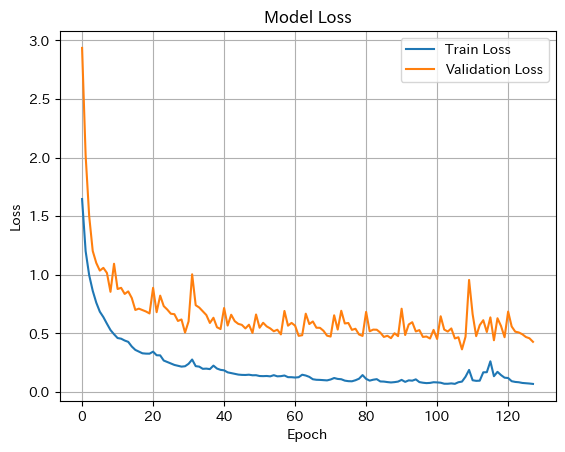

In [87]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=256,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=128,
                    return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=64,
                    return_sequences=False,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001)
                    )
)

lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(predict_length,
                     kernel_regularizer=regularizers.l2(0.001)
                     )
)


optimizer = optim.Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lstm_model.fit(X_train_scaled, y_train_scaled,
               epochs=1000,
               batch_size=64,
               validation_data=(X_valid_scaled, y_valid_scaled),
               shuffle=False,
               callbacks=[es])

# 検証データの損失が最も小さかったエポックを取得
best_epoch = np.argmin(lstm_model.history.history['val_loss']) + 1
print(f"検証データの損失が最も小さかったエポック: {best_epoch}")
# そのエポックの学習損失と検証損失を取得
best_train_loss = lstm_model.history.history['loss'][best_epoch - 1]
best_val_loss = lstm_model.history.history['val_loss'][best_epoch - 1]
print(f"エポック {best_epoch}での学習損失: {best_train_loss}")
print(f"エポック {best_epoch}での検証損失: {best_val_loss}")

# 損失関数の推移
plt.plot(lstm_model.history.history['loss'], label='Train Loss')
plt.plot(lstm_model.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [88]:
lstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60, 256)        │       288,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 60, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,610,180 (6.14 MB)

 Trainable params: 536,726 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,073,454 (4.09 MB)

In [89]:
'''
from sklearn.metrics import mean_squared_error

X_test = enbargo_valid_test.values[-sequence_length:]
X_test_scaled = scaler_X.transform(X_test).reshape(1, X_test.shape[0], X_test.shape[1])
print(X_test_scaled.shape)

y_test_pred_scaled = lstm_model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_pred = y_test_pred.flatten()
y_test_pred.shape

test_rmse = np.sqrt(mean_squared_error(test['close'].values, y_test_pred))

print(f"Test RMSE: {test_rmse}")
'''

'\nfrom sklearn.metrics import mean_squared_error\n\nX_test = enbargo_valid_test.values[-sequence_length:]\nX_test_scaled = scaler_X.transform(X_test).reshape(1, X_test.shape[0], X_test.shape[1])\nprint(X_test_scaled.shape)\n\ny_test_pred_scaled = lstm_model.predict(X_test_scaled)\ny_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)\ny_test_pred = y_test_pred.flatten()\ny_test_pred.shape\n\ntest_rmse = np.sqrt(mean_squared_error(test[\'close\'].values, y_test_pred))\n\nprint(f"Test RMSE: {test_rmse}")\n'

In [90]:
'''
plt.figure(figsize=(12,8))
plt.plot(engineered_df['2024-01-01':].index, engineered_df.loc['2024-01-01':, 'close'], label='実測値')
plt.plot(test.index, y_test_pred, label='予測値')
plt.title('終値の予測', fontsize=25)
plt.xlabel('日付', fontsize=20)
plt.ylabel('価格(円)', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()
'''

"\nplt.figure(figsize=(12,8))\nplt.plot(engineered_df['2024-01-01':].index, engineered_df.loc['2024-01-01':, 'close'], label='実測値')\nplt.plot(test.index, y_test_pred, label='予測値')\nplt.title('終値の予測', fontsize=25)\nplt.xlabel('日付', fontsize=20)\nplt.ylabel('価格(円)', fontsize=20)\nplt.legend(fontsize=20)\nplt.grid()\nplt.show()\n"

In [91]:
'''
plt.figure(figsize=(16,8))
plt.plot(test.index, test['close'].values, label='Actual')
plt.plot(test.index, y_test_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
'''

"\nplt.figure(figsize=(16,8))\nplt.plot(test.index, test['close'].values, label='Actual')\nplt.plot(test.index, y_test_pred, label='Predicted')\nplt.title('Stock Price Prediction')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.legend()\nplt.grid()\nplt.show()\n"